In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import solver

In [2]:
def differential_expression(f, x):
    f_prime = solver.calcGradients(f, x, 1)
    return f_prime - x - 1

def bc_function(x):
    return 0.0

bc_xs = [0.0]
bc_functions = [bc_function]
bc_ps = [0]

loss_fn = solver.LossFunction(differential_expression, bc_xs, bc_functions, bc_ps)

x_min = 0.0
x_max = 1.0
x_num = 200
x = np.linspace(x_min, x_max, x_num)
domain = [[x_min, x_max]]
dataloader = solver.genDataLoader(domain, discretization_num=x_num)

input_dim = 1
output_dim = 1
hidden_shapes = [50, 50]
model = solver.DNN(input_dim, hidden_shapes, output_dim)


num_epochs = 200
learning_rate = 0.01
loss_history = solver.training(model, loss_fn, dataloader, num_epochs, learning_rate, print_progress=True)

Epoch 1/200 Loss: 2.4466
Epoch 2/200 Loss: 2.2473
Epoch 3/200 Loss: 2.1869
Epoch 4/200 Loss: 2.0731
Epoch 5/200 Loss: 1.9279
Epoch 6/200 Loss: 1.7923
Epoch 7/200 Loss: 1.6643
Epoch 8/200 Loss: 1.5219
Epoch 9/200 Loss: 1.3549
Epoch 10/200 Loss: 1.1692
Epoch 11/200 Loss: 0.9777
Epoch 12/200 Loss: 0.7918
Epoch 13/200 Loss: 0.6169
Epoch 14/200 Loss: 0.4567
Epoch 15/200 Loss: 0.3215
Epoch 16/200 Loss: 0.2305
Epoch 17/200 Loss: 0.1961
Epoch 18/200 Loss: 0.2063
Epoch 19/200 Loss: 0.2457
Epoch 20/200 Loss: 0.3096
Epoch 21/200 Loss: 0.3704
Epoch 22/200 Loss: 0.3973
Epoch 23/200 Loss: 0.3899
Epoch 24/200 Loss: 0.3555
Epoch 25/200 Loss: 0.2994
Epoch 26/200 Loss: 0.2353
Epoch 27/200 Loss: 0.1802
Epoch 28/200 Loss: 0.1437
Epoch 29/200 Loss: 0.1270
Epoch 30/200 Loss: 0.1280
Epoch 31/200 Loss: 0.1421
Epoch 32/200 Loss: 0.1610
Epoch 33/200 Loss: 0.1759
Epoch 34/200 Loss: 0.1821
Epoch 35/200 Loss: 0.1787
Epoch 36/200 Loss: 0.1666
Epoch 37/200 Loss: 0.1478
Epoch 38/200 Loss: 0.1261
Epoch 39/200 Loss: 0.

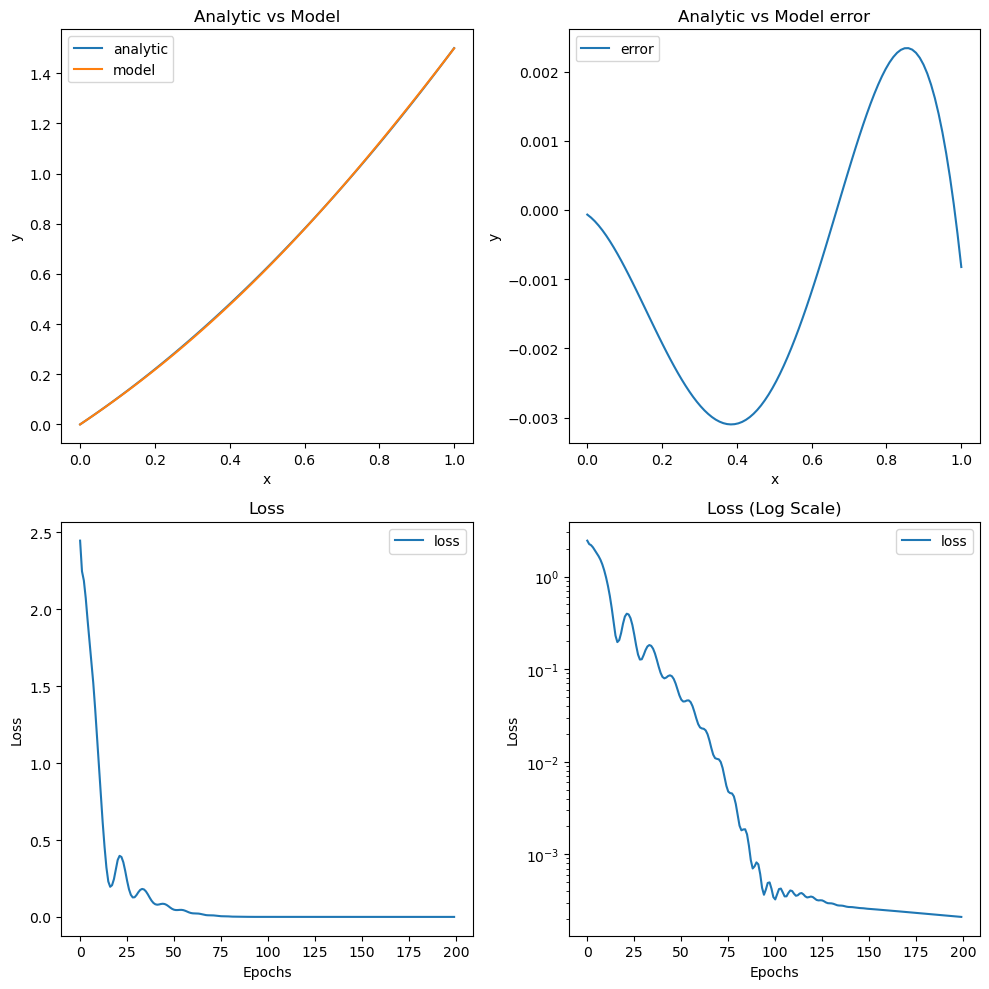

In [3]:
model.eval()

def analytic(x):
    return x**2 * 0.5 + x

x_eval = np.linspace(0,1,100)
y_analytic = analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Analytic vs Model error")

# Loss
axs[1, 0].plot(loss_history, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Loss (Log Scale)
axs[1, 1].plot(loss_history, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

For hyperparameter optimization with Ax see e.g. tutorial https://ax.dev/tutorials/tune_cnn_service.html

Hyperparameters to tune for here are:
- Number of layers
- Number of units in each layer
- Number of training examples
- Number of epochs
- Learning rate
- Domain extension (optionally)
- Number of batches
- Other additional parameters of Adam (optionally)

In [34]:
# Random search

class RandomNetworkGenerator:
    def __init__(self, max_depth, min_units, max_units):
        self.max_depth = max_depth
        self.min_units = min_units
        self.max_units = max_units
        self.generated_networks = []
    
    def genNext(self):
        depth = np.random.randint(1, self.max_depth)
        units = [np.random.randint(self.min_units, self.max_units) for _ in range(depth)]
        return units

max_depth = 10
min_units = 5
max_units = 500

generator = RandomNetworkGenerator(max_depth, min_units, max_units)


num_network_architectures = 100
random_networks = [generator.genNext() for _ in range(num_network_architectures)]

random_network_dict = {i+1:[] for i in range(max_depth)}
for n in random_networks:
    random_network_dict[len(n)].append(n)
for d in range(1,max_depth):
    print(d, random_network_dict[d])

# ...

1 [[319], [125], [151], [114], [470], [421], [343], [112], [299], [303]]
2 [[412, 330], [441, 325], [241, 159], [243, 362], [415, 259], [203, 241], [480, 378], [132, 148], [357, 351], [456, 472], [9, 137], [392, 224], [73, 143], [268, 366]]
3 [[20, 340, 188], [38, 23, 324], [405, 281, 346], [248, 455, 497], [127, 197, 278], [225, 410, 366], [273, 476, 12], [160, 227, 23], [193, 260, 44], [317, 179, 245]]
4 [[49, 337, 461, 167], [186, 380, 270, 328], [112, 150, 233, 409], [36, 277, 18, 224], [275, 202, 34, 222], [27, 308, 415, 303]]
5 [[429, 149, 270, 141, 252], [53, 52, 472, 412, 38], [278, 302, 353, 141, 291], [28, 227, 389, 162, 239], [330, 301, 309, 385, 56], [70, 175, 180, 366, 400], [188, 242, 212, 65, 241]]
6 [[299, 316, 164, 189, 38, 26], [303, 371, 353, 283, 482, 391], [262, 433, 173, 283, 482, 281], [172, 210, 182, 379, 142, 101], [218, 380, 240, 21, 213, 348], [139, 405, 87, 337, 14, 400], [315, 397, 286, 144, 372, 279], [224, 20, 454, 144, 253, 61], [210, 84, 302, 84, 325, 4

In [ ]:
# Grid search



In [18]:
# Bayesian search by Ax of each depth separately

from ax.service.ax_client import AxClient, ObjectiveProperties
from ax import ParameterType, RangeParameter, SearchSpace, Experiment


min_depth = 2
max_depth = 5
min_units = 4
max_units = 512

# For example
depth = 2

ax_client = AxClient()

# You could also include things like learning rate and such here
parameters = [{"name": "network_depth",
              "type": "fixed",
              "value": depth}]
for depth_i in range(depth):
    parameters.append(
        {"name": "units_layer{}".format(depth_i+1),
         "type": "range",
         "bounds": [min_units, max_units],
         "value_type": "int"
        }
    )

ax_client.create_experiment(
    name="solver_depth{}_optimization".format(depth),
    parameters=parameters,
    objectives={"train_evaluate": ObjectiveProperties(minimize=True)}
    )


def train_evaluate(parameters):
    # Ax parameter input parse
    depth = parameters["network_depth"]
    hidden_shapes = []
    for depth_i in range(depth):
        hidden_shapes.append(parameters["units_layer{}".format(depth_i+1)])
    
    # Training
    loss_fn = solver.LossFunction(differential_expression, bc_xs, bc_functions, bc_ps)

    x_min = 0.0
    x_max = 1.0
    x_num = 200
    x = np.linspace(x_min, x_max, x_num)
    domain = [[x_min, x_max]]
    dataloader = solver.genDataLoader(domain, discretization_num=x_num)

    input_dim = 1
    output_dim = 1
    hidden_shapes = hidden_shapes
    model = solver.DNN(input_dim, hidden_shapes, output_dim)


    num_epochs = 100
    learning_rate = 0.01
    loss_history = solver.training(model, loss_fn, dataloader, num_epochs, learning_rate)
    
    # Evaluation by final training loss
    return loss_history[-1]



# __Search__

# A good first example
ax_client.attach_trial(
    parameters={"network_depth": depth, "units_layer1": 50, "units_layer2": 50}
)
baseline_parameters = ax_client.get_trial_parameters(trial_index=0)
ax_client.complete_trial(trial_index=0, raw_data=train_evaluate(baseline_parameters))

# Iteration
num_iterations = 100
for i in range(num_iterations):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=train_evaluate(parameters))

[INFO 06-18 23:16:33] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 06-18 23:16:33] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[FixedParameter(name='network_depth', parameter_type=INT, value=2), RangeParameter(name='units_layer1', parameter_type=INT, range=[4, 512]), RangeParameter(name='units_layer2', parameter_type=INT, range=[4, 512])], parameter_constraints=[]).
[INFO 06-18 23:16:33] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 06-18 23:16:33] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=2 num_trials=None use_batch_trials=False
[INFO 06-18

[INFO 06-18 23:17:06] ax.service.ax_client: Generated new trial 23 with parameters {'units_layer1': 325, 'units_layer2': 180, 'network_depth': 2} using model BoTorch.
[INFO 06-18 23:17:07] ax.service.ax_client: Completed trial 23 with data: {'train_evaluate': (0.000386, None)}.
[INFO 06-18 23:17:08] ax.service.ax_client: Generated new trial 24 with parameters {'units_layer1': 123, 'units_layer2': 249, 'network_depth': 2} using model BoTorch.
[INFO 06-18 23:17:09] ax.service.ax_client: Completed trial 24 with data: {'train_evaluate': (0.000251, None)}.
[INFO 06-18 23:17:09] ax.service.ax_client: Generated new trial 25 with parameters {'units_layer1': 4, 'units_layer2': 267, 'network_depth': 2} using model BoTorch.
[INFO 06-18 23:17:10] ax.service.ax_client: Completed trial 25 with data: {'train_evaluate': (0.100001, None)}.
[INFO 06-18 23:17:11] ax.service.ax_client: Generated new trial 26 with parameters {'units_layer1': 458, 'units_layer2': 312, 'network_depth': 2} using model BoTorch

[INFO 06-18 23:17:56] ax.service.ax_client: Completed trial 49 with data: {'train_evaluate': (3.6e-05, None)}.
[INFO 06-18 23:17:57] ax.service.ax_client: Generated new trial 50 with parameters {'units_layer1': 435, 'units_layer2': 149, 'network_depth': 2} using model BoTorch.
[INFO 06-18 23:17:58] ax.service.ax_client: Completed trial 50 with data: {'train_evaluate': (0.000204, None)}.
/home/joonas/.local/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[INFO 06-18 23:17:59] ax.service.ax_client: Generated new trial 51 with parameters {'units_layer1': 458, 'units_layer2': 466, 'network_depth': 2} using model BoTorch.
[INFO 06-18 23:18:01] ax.service.ax_client: Completed trial 51 with data: {'train_evaluate': (0.000217, None)}.
[INFO 06-18 23:18:02] ax.service.ax_client: Generated new trial 52 with parameters {'units_layer1': 474, 'units_layer2': 338, 'network_depth': 2} using model BoTorch.
[INFO

[INFO 06-18 23:18:58] ax.service.ax_client: Completed trial 76 with data: {'train_evaluate': (0.000413, None)}.
[INFO 06-18 23:18:59] ax.service.ax_client: Generated new trial 77 with parameters {'units_layer1': 512, 'units_layer2': 108, 'network_depth': 2} using model BoTorch.
[INFO 06-18 23:19:00] ax.service.ax_client: Completed trial 77 with data: {'train_evaluate': (4.7e-05, None)}.
[INFO 06-18 23:19:01] ax.service.ax_client: Generated new trial 78 with parameters {'units_layer1': 496, 'units_layer2': 126, 'network_depth': 2} using model BoTorch.
[INFO 06-18 23:19:02] ax.service.ax_client: Completed trial 78 with data: {'train_evaluate': (4.1e-05, None)}.
[INFO 06-18 23:19:04] ax.service.ax_client: Generated new trial 79 with parameters {'units_layer1': 501, 'units_layer2': 94, 'network_depth': 2} using model BoTorch.
[INFO 06-18 23:19:05] ax.service.ax_client: Completed trial 79 with data: {'train_evaluate': (1.9e-05, None)}.
[INFO 06-18 23:19:06] ax.service.ax_client: Generated n

In [19]:
# ax_client.get_trials_data_frame()

In [20]:
best_parameters, values = ax_client.get_best_parameters()
print("Best parameters:", best_parameters)
print("Values:", values)

({'units_layer1': 503, 'units_layer2': 109, 'network_depth': 2},
 ({'train_evaluate': 5.702987714890676e-05},
  {'train_evaluate': {'train_evaluate': 6.545307102842407e-10}}))

In [21]:
from ax.utils.notebook.plotting import init_notebook_plotting, render

render(ax_client.get_contour_plot(param_x="units_layer1", param_y="units_layer2"))

[INFO 06-18 23:20:00] ax.service.ax_client: Retrieving contour plot with parameter 'units_layer1' on X-axis and 'units_layer2' on Y-axis, for metric 'train_evaluate'. Remaining parameters are affixed to the middle of their range.


In [22]:
render(
    ax_client.get_optimization_trace()
) 